In [1]:
import os
import gzip
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from utilsData import load_data_from_patients_folder, add_mean_SUV_index, plot_connectome

In [14]:
patients_data = load_data_from_patients_folder("../Data/PATIENTS")
patients_data = add_mean_SUV_index(patients_data)

controls_data = load_data_from_patients_folder("../Data/CONTROLES")
controls_data = add_mean_SUV_index(controls_data)

patients = patients_data.keys()
controls = controls_data.keys()

names = patients_data[list(patients)[0]].loc["name"]
names = names.to_numpy()

# Verify the contents
print(f"Loaded data for {len(patients_data)}-{len(controls_data)} patients.")


Loaded data for 27-53 patients.


In [15]:
mean_SUV_by_names = {name: [patients_data[patient].loc[:, patients_data[patient].iloc[0] == name].loc["mean_SUV"].to_numpy()[0] for patient in patients] for name in names}
mean_SUV_by_names_controls = {name: [controls_data[patient].loc[:, controls_data[patient].iloc[0] == name].loc["mean_SUV"].to_numpy()[0] for patient in controls] for name in names}

#mean_SUV_by_names

In [16]:
# Convert the dictionary into a DataFrame
mean_SUV_by_names_df = pd.DataFrame(mean_SUV_by_names)
mean_SUV_by_names_controls_df = pd.DataFrame(mean_SUV_by_names_controls)


# Calculate the correlation matrix
correlation_matrix = mean_SUV_by_names_df.corr()
correlation_matrix_control = mean_SUV_by_names_controls_df.corr()

#print(correlation_matrix)

## "PATIENTS" Group

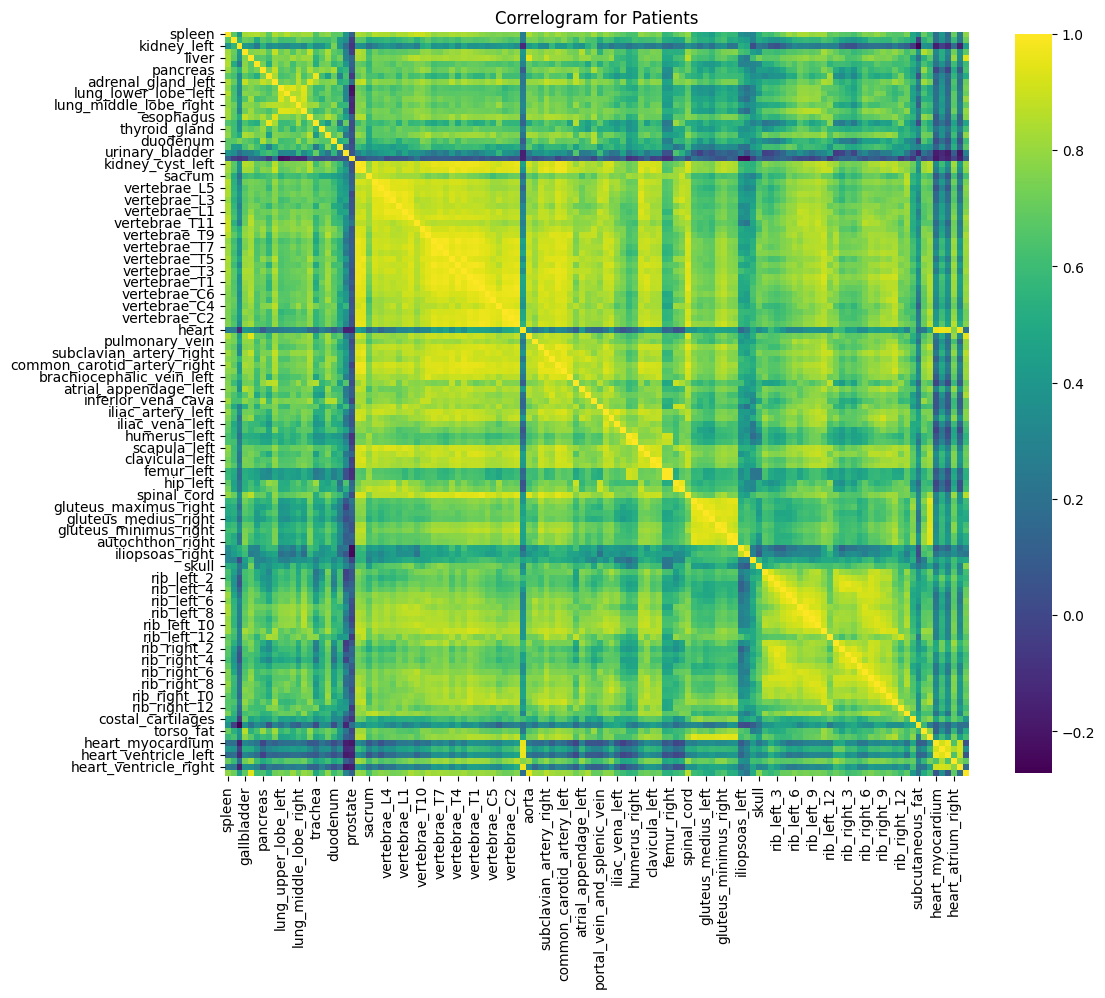

In [17]:
plt.figure(figsize=(12, 12))
sns.heatmap(
    correlation_matrix,
    annot=False,
    cmap='viridis',  # You can change this to another colormap like 'viridis' or 'RdBu_r'
    fmt='.2f',
    linewidths=0,  # Increase linewidth for better separation between cells
    cbar_kws={"shrink": 0.8},  # Shrink colorbar for better aesthetics
    annot_kws={"size": 12},  # Set font size of annotations
    square=True,  # Make the heatmap square-shaped
    linecolor='white'  # Add white lines between cells
)
plt.title('Correlogram for Patients')
plt.show()

In [18]:
correlation_matrix

,spleen,kidney_right,kidney_left,gallbladder,liver,stomach,pancreas,adrenal_gland_right,adrenal_gland_left,lung_upper_lobe_left,...,costal_cartilages,subcutaneous_fat,torso_fat,skeletal_muscle,heart_myocardium,heart_atrium_left,heart_ventricle_left,heart_atrium_right,heart_ventricle_right,pulmonary_artery
spleen,1.000000,0.662702,0.399816,0.825475,0.836127,0.849965,0.802205,0.673214,0.843235,0.792373,...,0.475201,0.374662,0.702812,0.581370,0.186522,0.401813,0.163537,0.705891,0.250532,0.781679
kidney_right,0.662702,1.000000,0.553040,0.703519,0.683158,0.507790,0.664655,0.622056,0.701681,0.609375,...,0.491363,-0.034453,0.541293,0.631592,0.185182,0.372406,0.192081,0.587209,0.244016,0.713016
kidney_left,0.399816,0.553040,1.000000,0.409863,0.379912,0.241217,0.535033,0.331167,0.387438,0.341496,...,-0.048897,-0.272057,0.388650,0.348159,-0.164711,-0.029964,-0.120875,0.181154,-0.159801,0.434670
gallbladder,0.825475,0.703519,0.409863,1.000000,0.753472,0.773759,0.791149,0.669868,0.883780,0.713491,...,0.688578,0.390457,0.857310,0.771603,0.316208,0.520328,0.309033,0.726080,0.361395,0.684430
liver,0.836127,0.683158,0.379912,0.753472,1.000000,0.662695,0.672874,0.607840,0.773785,0.759774,...,0.470361,0.208946,0.541831,0.671302,0.264051,0.512855,0.251472,0.801512,0.344965,0.937810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
heart_atrium_left,0.401813,0.372406,-0.029964,0.520328,0.512855,0.369950,0.190655,0.310857,0.358650,0.395282,...,0.663769,0.270157,0.372587,0.591036,0.907830,1.000000,0.931036,0.843058,0.918791,0.356987
heart_ventricle_left,0.163537,0.192081,-0.120875,0.309033,0.251472,0.174500,-0.019665,0.153063,0.136971,0.156841,...,0.515162,0.139223,0.168026,0.400144,0.974576,0.931036,1.000000,0.639318,0.896436,0.075176
heart_atrium_right,0.705891,0.587209,0.181154,0.726080,0.801512,0.599031,0.500743,0.559759,0.638854,0.616363,...,0.694026,0.311684,0.570662,0.736171,0.641829,0.843058,0.639318,1.000000,0.772179,0.682972
heart_ventricle_right,0.250532,0.244016,-0.159801,0.361395,0.344965,0.273605,0.083737,0.233583,0.193378,0.209995,...,0.597919,0.195620,0.227293,0.449850,0.907109,0.918791,0.896436,0.772179,1.000000,0.173026


The fully connected connectome

In [19]:
G = nx.Graph()
G.add_nodes_from(names)

for i in range(len(names)):
    for j in range(i + 1, len(names)):  # Only upper triangle (undirected graph)
        if correlation_matrix.loc[names[i], names[j]] != 0:  # Threshold to determine if an edge exists
            G.add_edge(names[i], names[j], weight=correlation_matrix.loc[names[i], names[j]])

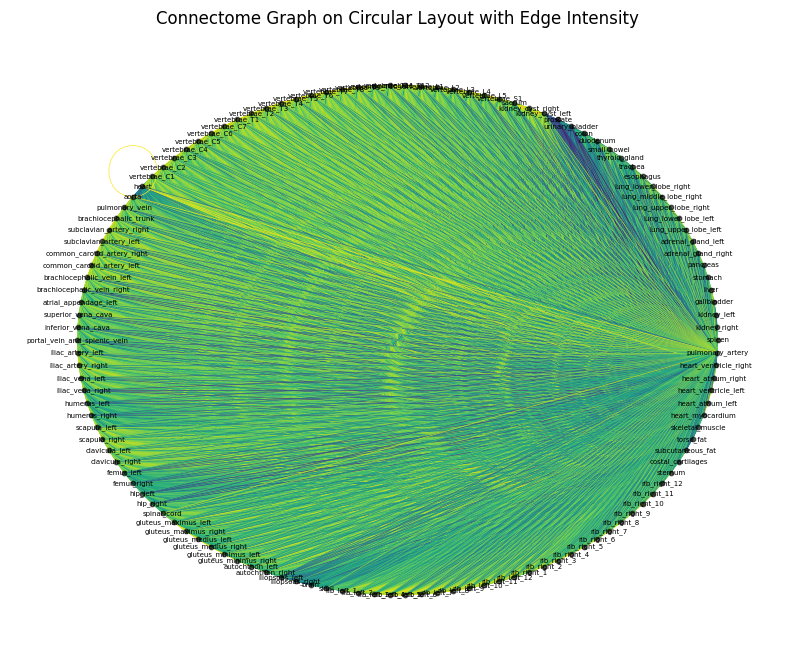

In [20]:
plot_connectome(G)

Let's make it sparser...

In [21]:
print(np.mean(correlation_matrix.to_numpy()))
print(np.max(correlation_matrix.to_numpy()))
print(np.min(correlation_matrix.to_numpy()))
print(np.mean(abs(correlation_matrix.to_numpy())))
print(np.median(abs(correlation_matrix.to_numpy())))
print(np.quantile(abs(correlation_matrix.to_numpy()), q=0.90))



0.6541608928022475
1.0
-0.2720565235762843
0.6554596917737132
0.6971165986996379
0.8816597824220844


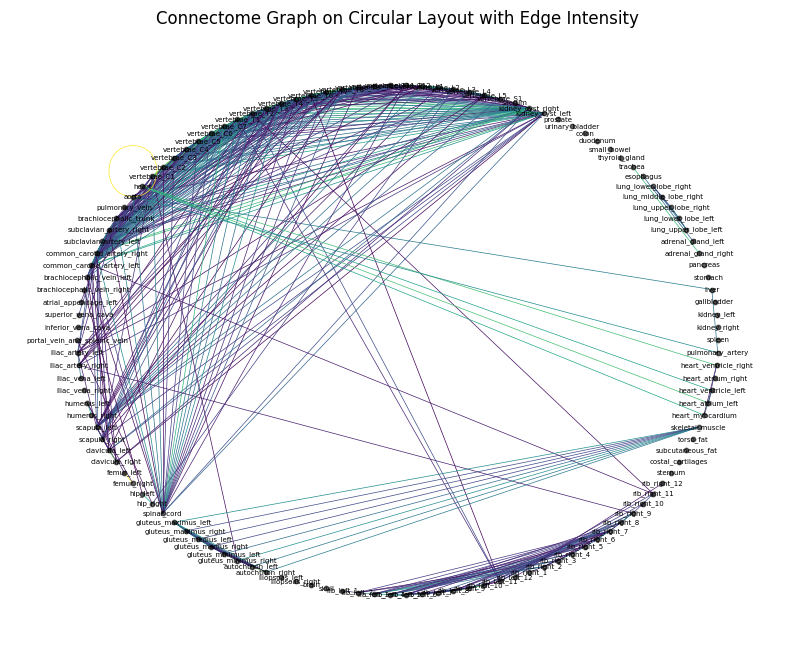

In [22]:
G_sparse = nx.Graph()
G_sparse.add_nodes_from(names)

for i in range(len(names)):
    for j in range(i + 1, len(names)):  # Only upper triangle (undirected graph)
        if abs(correlation_matrix.loc[names[i], names[j]]) > 0.9:  # Threshold to determine if an edge exists
            G_sparse.add_edge(names[i], names[j], weight=correlation_matrix.loc[names[i], names[j]])

plot_connectome(G_sparse)

## "CONTROLES" Group

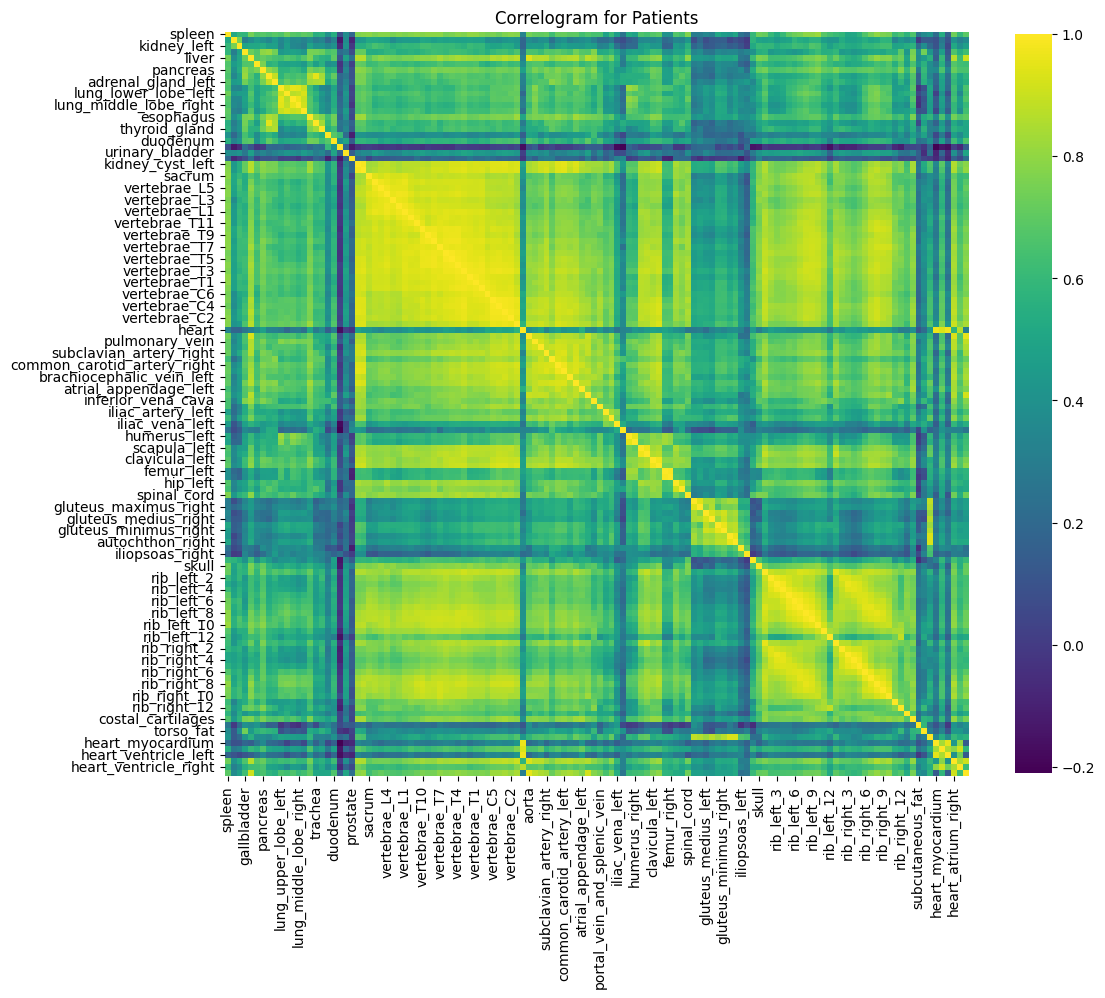

In [23]:
plt.figure(figsize=(12, 12))
sns.heatmap(
    correlation_matrix_control,
    annot=False,
    cmap='viridis',  # You can change this to another colormap like 'viridis' or 'RdBu_r'
    fmt='.2f',
    linewidths=0,  # Increase linewidth for better separation between cells
    cbar_kws={"shrink": 0.8},  # Shrink colorbar for better aesthetics
    annot_kws={"size": 12},  # Set font size of annotations
    square=True,  # Make the heatmap square-shaped
    linecolor='white'  # Add white lines between cells
)
plt.title('Correlogram for Patients')
plt.show()

In [24]:
correlation_matrix_control

,spleen,kidney_right,kidney_left,gallbladder,liver,stomach,pancreas,adrenal_gland_right,adrenal_gland_left,lung_upper_lobe_left,...,costal_cartilages,subcutaneous_fat,torso_fat,skeletal_muscle,heart_myocardium,heart_atrium_left,heart_ventricle_left,heart_atrium_right,heart_ventricle_right,pulmonary_artery
spleen,1.000000,0.515568,0.588829,0.581221,0.740894,0.667084,0.680004,0.658280,0.687739,0.663119,...,0.660256,0.266806,0.370933,0.416209,0.211936,0.540218,0.172671,0.733653,0.589971,0.691826
kidney_right,0.515568,1.000000,0.750062,0.300891,0.376609,0.447093,0.398423,0.348155,0.448448,0.347328,...,0.437316,-0.002557,0.127551,0.129637,0.090634,0.275392,0.105348,0.403488,0.312016,0.368376
kidney_left,0.588829,0.750062,1.000000,0.492784,0.509988,0.514214,0.534686,0.468230,0.471666,0.337160,...,0.573497,0.209257,0.381749,0.202788,0.097651,0.313532,0.054877,0.516697,0.388307,0.467511
gallbladder,0.581221,0.300891,0.492784,1.000000,0.724143,0.665399,0.792465,0.812930,0.737429,0.434718,...,0.747783,0.390524,0.738001,0.419859,0.183735,0.462124,0.113706,0.662056,0.553700,0.628050
liver,0.740894,0.376609,0.509988,0.724143,1.000000,0.673692,0.711512,0.676075,0.643520,0.624328,...,0.765354,0.367624,0.450802,0.551947,0.150261,0.593650,0.155096,0.866019,0.626254,0.907821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
heart_atrium_left,0.540218,0.275392,0.313532,0.462124,0.593650,0.554082,0.657959,0.508328,0.479321,0.474217,...,0.591790,0.249942,0.334801,0.539549,0.836419,1.000000,0.851424,0.785011,0.909877,0.583699
heart_ventricle_left,0.172671,0.105348,0.054877,0.113706,0.155096,0.240636,0.346152,0.232519,0.223488,0.197622,...,0.244364,-0.014993,0.106440,0.365357,0.948585,0.851424,1.000000,0.395284,0.730867,0.132077
heart_atrium_right,0.733653,0.403488,0.516697,0.662056,0.866019,0.674531,0.719932,0.608318,0.589004,0.630053,...,0.802575,0.409888,0.439098,0.599003,0.436632,0.785011,0.395284,1.000000,0.841549,0.908369
heart_ventricle_right,0.589971,0.312016,0.388307,0.553700,0.626254,0.628950,0.653895,0.498338,0.486284,0.447458,...,0.652321,0.330902,0.437892,0.534386,0.793852,0.909877,0.730867,0.841549,1.000000,0.619614


The fully connected connectome

In [25]:
G_control = nx.Graph()
G_control.add_nodes_from(names)

for i in range(len(names)):
    for j in range(i + 1, len(names)):  # Only upper triangle (undirected graph)
        if correlation_matrix_control.loc[names[i], names[j]] != 0:  # Threshold to determine if an edge exists
            G_control.add_edge(names[i], names[j], weight=correlation_matrix_control.loc[names[i], names[j]])

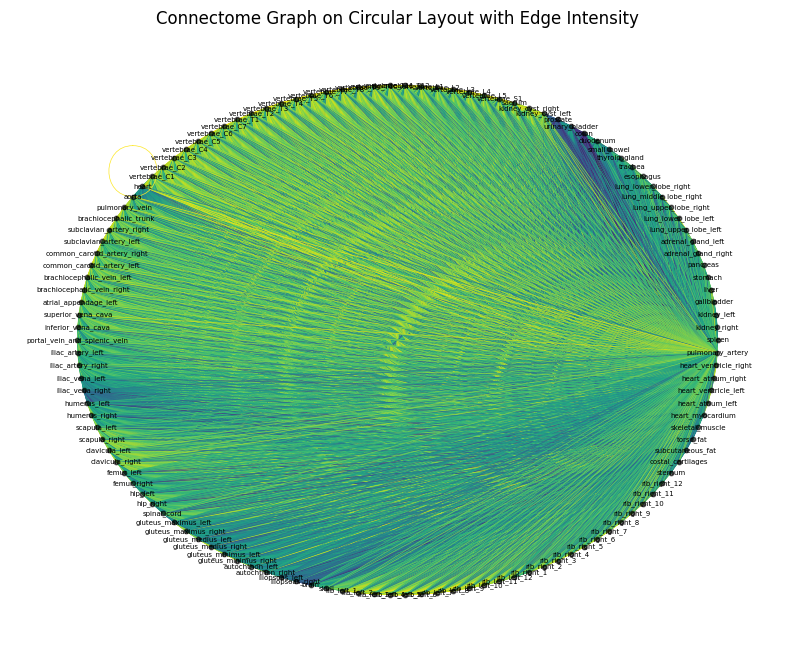

In [26]:
plot_connectome(G_control)

Let's make it sparser...

In [27]:
print(np.mean(correlation_matrix_control.to_numpy()))
print(np.max(correlation_matrix_control.to_numpy()))
print(np.min(correlation_matrix_control.to_numpy()))
print(np.mean(abs(correlation_matrix_control.to_numpy())))
print(np.median(abs(correlation_matrix_control.to_numpy())))
print(np.quantile(abs(correlation_matrix_control.to_numpy()), q=0.90))



0.6037069742527188
1.0
-0.21001285007439088
0.6048355253259936
0.633486799385782
0.8746764468987509


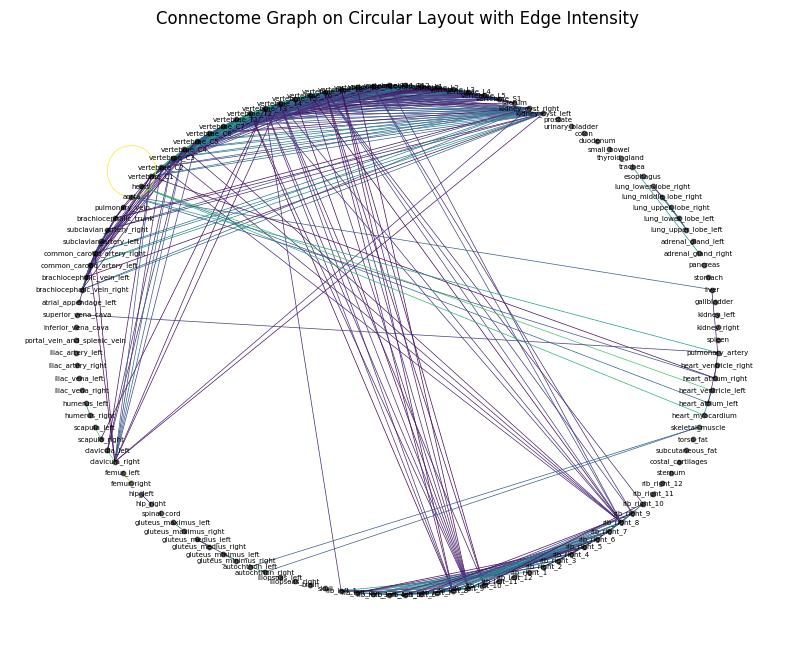

: 

In [28]:
G_sparse_control = nx.Graph()
G_sparse_control.add_nodes_from(names)

for i in range(len(names)):
    for j in range(i + 1, len(names)):  # Only upper triangle (undirected graph)
        if abs(correlation_matrix_control.loc[names[i], names[j]]) > 0.9:  # Threshold to determine if an edge exists
            G_sparse_control.add_edge(names[i], names[j], weight=correlation_matrix_control.loc[names[i], names[j]])

plot_connectome(G_sparse_control)